## Using a Deep Neural Network to Predict the All-NBA Teams for the 2019-20 NBA Season 

### Import standard libraries


In [1]:
import pandas as pd
import pandas_profiling
from pandas_profiling import ProfileReport
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
plt.style.use('fivethirtyeight')
%matplotlib inline

### Read All-NBA (1988-2019) data from Wikipedia

In [2]:
df = pd.read_html('https://en.wikipedia.org/wiki/All-NBA_Team', header=None)[7]

In [3]:
df.head()

Season              First team                             Second team  \
    Season                 Players               Teams             Players   
0  1988–89        Karl Malone* (2)           Utah Jazz        Tom Chambers   
1  1988–89    Charles Barkley* (4)  Philadelphia 76ers       Chris Mullin*   
2  1988–89  Akeem Olajuwon* (4)[c]     Houston Rockets  Patrick Ewing* (2)   
3  1988–89     Michael Jordan* (4)       Chicago Bulls  John Stockton* (2)   
4  1988–89      Magic Johnson* (8)  Los Angeles Lakers       Kevin Johnson   

                                      Third team                       
                   Teams                 Players                Teams  
0           Phoenix Suns  Dominique Wilkins* (4)        Atlanta Hawks  
1  Golden State Warriors      Terry Cummings (2)      Milwaukee Bucks  
2        New York Knicks      Robert Parish* (2)       Boston Celtics  
3              Utah Jazz              Dale Ellis  Seattle SuperSonics  
4           Phoenix Suns              Mark Price  Cleveland Cavaliers

### Cleanup All-NBA Data

In [4]:
df.columns = df.columns.droplevel() # Drop first levl of header

df.drop('Teams', axis = 1, inplace= True) # Drop the Team columns

In [5]:
df.columns = ['season', 'first_team', 'second_team', 'third_team' ]

In [6]:
#Strip () and [] from names

df['first_team'] = df['first_team'].apply(lambda x: re.sub(r'\([^)]*\)', '', x)).apply(lambda x: re.sub(r'\[[^)]*\]', '', x)).apply(lambda x: x.replace('^', ''))
df['second_team'] = df['second_team'].apply(lambda x: re.sub(r'\([^)]*\)', '', x)).apply(lambda x: re.sub(r'\[[^)]*\]', '', x)).apply(lambda x: x.replace('^', ''))
df['third_team'] = df['third_team'].apply(lambda x: re.sub(r'\([^)]*\)', '', x)).apply(lambda x: re.sub(r'\[[^)]*\]', '', x)).apply(lambda x: x.replace('^', ''))

In [7]:
df.head()

,season,first_team,second_team,third_team
0,1988–89,Karl Malone*,Tom Chambers,Dominique Wilkins*
1,1988–89,Charles Barkley*,Chris Mullin*,Terry Cummings
2,1988–89,Akeem Olajuwon*,Patrick Ewing*,Robert Parish*
3,1988–89,Michael Jordan*,John Stockton*,Dale Ellis
4,1988–89,Magic Johnson*,Kevin Johnson,Mark Price


### Data Engineering to prepare for Machine Learning

In [8]:
df['1st'] = '1st'
df['2nd'] = '2nd'
df['3rd'] = '3rd' 

In [9]:
df1st = pd.DataFrame()
df2nd = pd.DataFrame()
df3rd = pd.DataFrame()
df1st[['season', 'player', 'all_nba_team']] = df[['season', 'first_team', '1st']]
df2nd[['season', 'player', 'all_nba_team']] = df[['season', 'second_team', '2nd']]
df3rd[['season', 'player', 'all_nba_team']] = df[['season', 'third_team', '3rd']]

In [10]:
all_nba_df = df1st.append([df2nd, df3rd], ignore_index=True)

In [11]:
all_nba_df.head()

,season,player,all_nba_team
0,1988–89,Karl Malone*,1st
1,1988–89,Charles Barkley*,1st
2,1988–89,Akeem Olajuwon*,1st
3,1988–89,Michael Jordan*,1st
4,1988–89,Magic Johnson*,1st


### Further cleaning up ALL-NBA data 

In [12]:
def remove_trail_space(player):
    if player[-1] == ' ':
        player = player[0:-1]
        return player
    else:
        return player
    
all_nba_df['player'] = all_nba_df['player'].apply(remove_trail_space)

#Clean up players with dfferent names

all_nba_df['season'] = all_nba_df['season'].apply(lambda x: x.replace('–', '-'))
all_nba_df['player'] = all_nba_df['player'].apply(lambda x: x.replace('*', ''))

all_nba_df['player'].loc[all_nba_df['player'] == 'Amare Stoudemire'] = 'Amar\'e Stoudemire' 

all_nba_df['player'].loc[all_nba_df['player'] == 'Akeem Olajuwon'] = 'Hakeem Olajuwon'

all_nba_df['player'].loc[all_nba_df['player'] == 'Penny Hardaway'] = 'Anfernee Hardaway'

all_nba_df['player'].loc[all_nba_df['player'] == 'Ron Artest'] = 'Metta World Peace'

all_nba_df.head()

,season,player,all_nba_team
0,1988-89,Karl Malone,1st
1,1988-89,Charles Barkley,1st
2,1988-89,Hakeem Olajuwon,1st
3,1988-89,Michael Jordan,1st
4,1988-89,Magic Johnson,1st


## Read historical NBA stats (1989 - 2020)

In [13]:
nba_df = pd.read_csv('nba_data_scrape.csv')

In [14]:
nba_df.head()

,player,age,tm,season_start,season,g,gs,mp,fg,fga,...,obpm,dbpm,bpm,vorp,debut,years_pro,player_id,salary,salary cap,%_of_cap
0,Steven Adams,26,OKC,2019,2019-20,58,58,1564,262,443,...,2.1,1.1,3.2,2.0,2013,7,stevenadams,25842700.0,109140000.0,0.236785
1,Bam Adebayo,22,MIA,2019,2019-20,65,65,2235,408,719,...,1.6,2.1,3.6,3.2,2017,3,bamadebayo,3454080.0,109140000.0,0.031648
2,LaMarcus Aldridge,34,SAS,2019,2019-20,53,53,1754,391,793,...,1.8,-0.5,1.3,1.5,2006,14,lamarcusaldridge,26000000.0,109140000.0,0.238226
3,Nickeil Alexander-Walker,21,NOP,2019,2019-20,41,0,501,77,227,...,-3.5,-1.4,-4.9,-0.4,2019,1,nickeilalexanderwalker,2964840.0,109140000.0,0.027165
4,Grayson Allen,24,MEM,2019,2019-20,30,0,498,79,176,...,-1.0,-1.5,-2.6,-0.1,2018,2,graysonallen,2429400.0,109140000.0,0.022260


### Add per game statitics to historical Dataframe (pts/g, ast/g, etc.)

In [15]:
per_game_cols = ['mp', 'orb', 'drb', 'trb',
           'ast', 'stl', 'blk', 'tov', 'pf', 'pts']

for column in per_game_cols:
    nba_df[column+'/g'] = round(nba_df[column]/nba_df.g, 1)

### Merge Databases

In [16]:
nba_df = pd.merge(nba_df, all_nba_df, how='left', on=['player', 'season'])

In [17]:
nba_df.head()

,player,age,tm,season_start,season,g,gs,mp,fg,fga,...,orb/g,drb/g,trb/g,ast/g,stl/g,blk/g,tov/g,pf/g,pts/g,all_nba_team
0,Steven Adams,26,OKC,2019,2019-20,58,58,1564,262,443,...,3.4,6.0,9.4,2.4,0.9,1.1,1.5,1.9,10.9,NaN
1,Bam Adebayo,22,MIA,2019,2019-20,65,65,2235,408,719,...,2.5,8.0,10.5,5.1,1.2,1.3,2.8,2.5,16.2,NaN
2,LaMarcus Aldridge,34,SAS,2019,2019-20,53,53,1754,391,793,...,1.9,5.5,7.4,2.4,0.7,1.6,1.4,2.4,18.9,NaN
3,Nickeil Alexander-Walker,21,NOP,2019,2019-20,41,0,501,77,227,...,0.2,1.8,2.0,1.8,0.3,0.2,1.0,1.1,5.1,NaN
4,Grayson Allen,24,MEM,2019,2019-20,30,0,498,79,176,...,0.2,2.0,2.2,1.4,0.2,0.0,0.8,1.2,7.4,NaN


### Replace non-winners (NAN) with NO

In [18]:
nba_df.all_nba_team.fillna('no', inplace=True)

# Data Visualization 

Text(0, 0.5, 'Total Players')

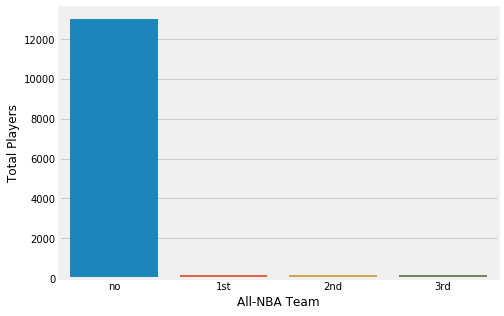

In [71]:
plt.figure(figsize=(7, 5))
sns.countplot(x='all_nba_team', data=nba_df[nba_df.season != '2019-20'])
plt.xlabel('All-NBA Team')
plt.ylabel('Total Players')

Data is heavily skewed towards non-winners. This make sense as there are only 15 All-NBA recipients per year 

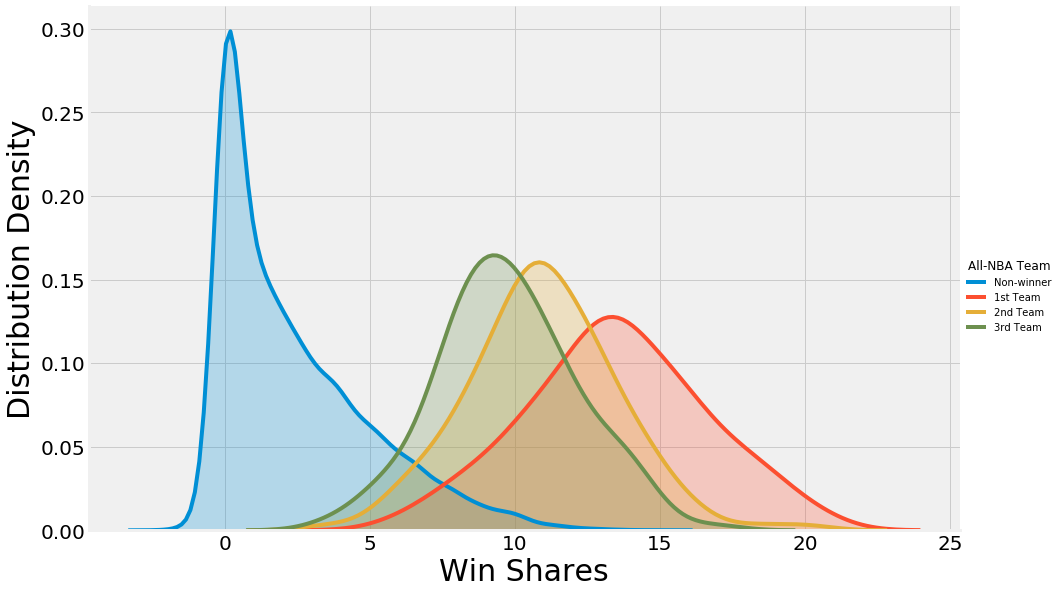

In [20]:
g = sns.FacetGrid(nba_df[nba_df.season != '2019-20'],
                   hue="all_nba_team", height=8, aspect=1.6)
g = g.map(sns.kdeplot, "ws", shade=True).add_legend()

plt.xlabel('Win Shares', fontsize=30)
plt.ylabel('Distribution Density', fontsize=30)
g._legend.set_title("All-NBA Team")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# replace labels
new_labels = ['Non-winner', '1st Team', '2nd Team', '3rd Team']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)
g.savefig('WS_allNBA.pdf', bbox_inches='tight')

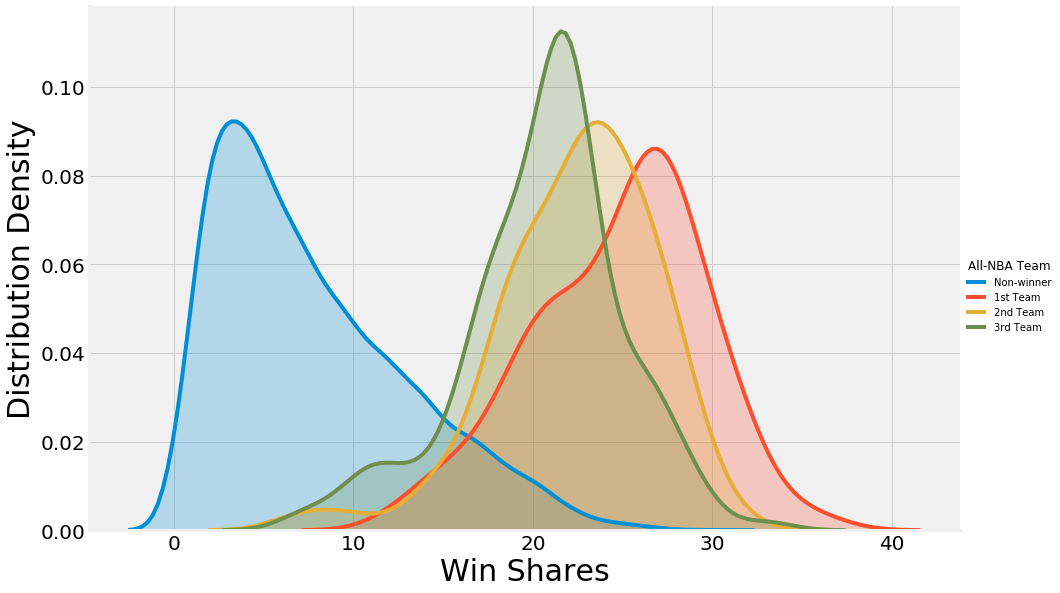

In [21]:
g = sns.FacetGrid(nba_df[nba_df.season != '2019-20'],
                  hue = "all_nba_team", height = 8, aspect = 1.6)
g = g.map(sns.kdeplot, "pts/g", shade = True).add_legend()
plt.xlabel('Win Shares', fontsize = 30)
plt.ylabel('Distribution Density', fontsize = 30)
g._legend.set_title("All-NBA Team")
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
# replace labels
new_labels = ['Non-winner', '1st Team', '2nd Team', '3rd Team']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)
#g.savefig('WS_allNBA.pdf', bbox_inches = 'tight')

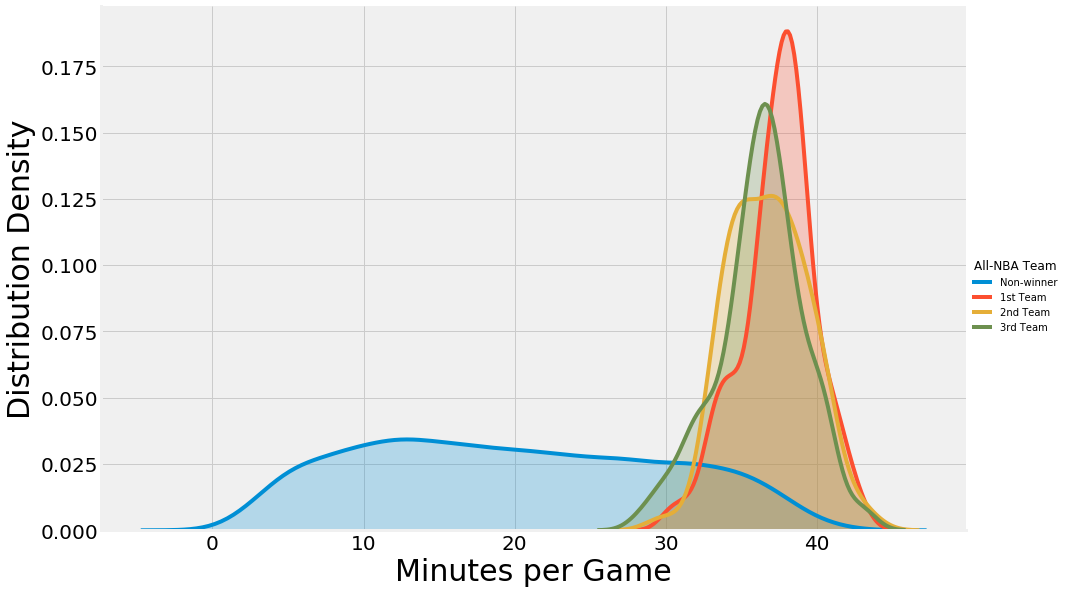

In [22]:
g = sns.FacetGrid(nba_df[nba_df.season != '2019-20'],
                  hue="all_nba_team", height=8, aspect=1.6)
g = g.map(sns.kdeplot, "mp/g", shade=True).add_legend()

plt.xlabel('Minutes per Game', fontsize = 30)
plt.ylabel('Distribution Density', fontsize = 30)
g._legend.set_title("All-NBA Team")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# replace labels
new_labels = ['Non-winner', '1st Team', '2nd Team', '3rd Team']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)
g.savefig('MPG_allNBA.pdf', bbox_inches='tight')

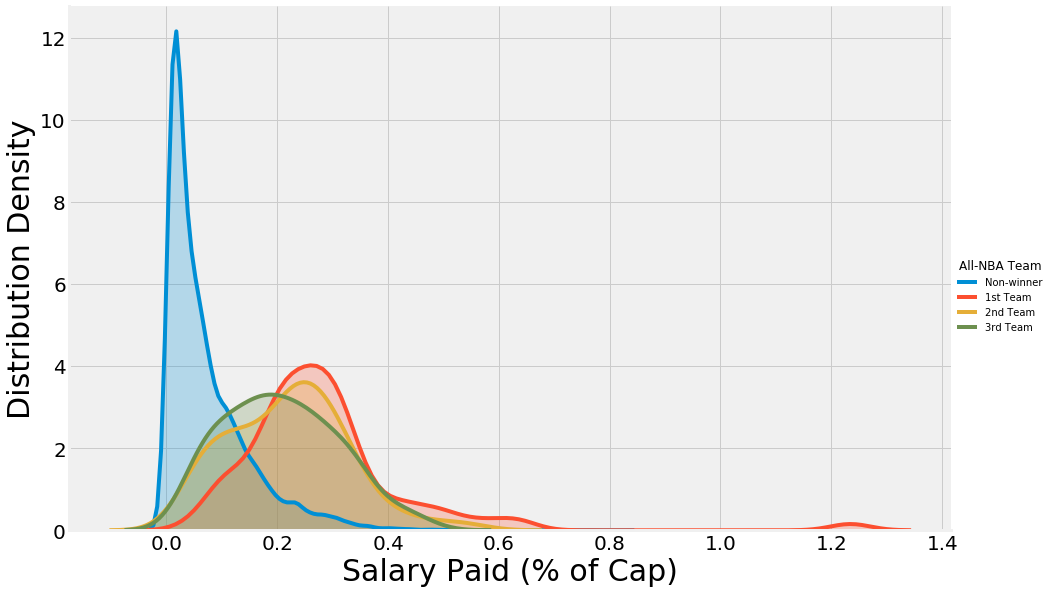

In [23]:
g = sns.FacetGrid(nba_df[nba_df.season != '2019-20'],
                   hue="all_nba_team", height=8, aspect=1.6)
g = g.map(sns.kdeplot, "%_of_cap", shade=True).add_legend()

plt.xlabel('Salary Paid (% of Cap)', fontsize=30)
plt.ylabel('Distribution Density', fontsize=30)
g._legend.set_title("All-NBA Team")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# replace labels
new_labels = ['Non-winner', '1st Team', '2nd Team', '3rd Team']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)
g.savefig('WS_allNBA.pdf', bbox_inches='tight')

## Combine images in one figure

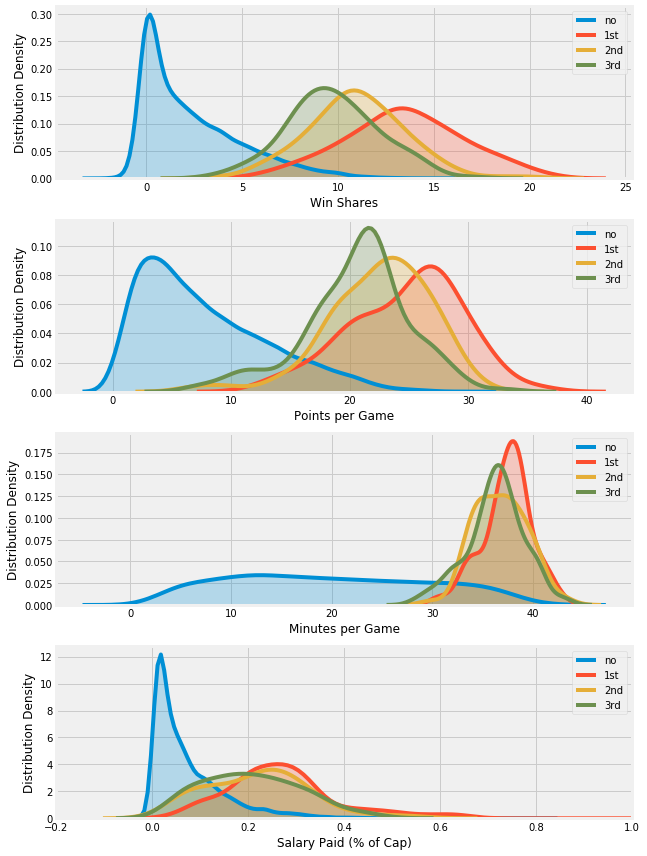

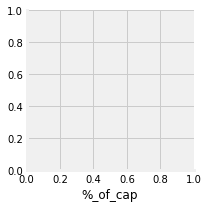

In [24]:
f, axes = plt.subplots(nrows=4, figsize =(9,12))

p = sns.FacetGrid(nba_df[nba_df.season != '2019-20'], hue="all_nba_team")

axes[0].set(xlabel='Win Shares', ylabel='Distribution Density')
p.map(sns.kdeplot, "ws", shade=True, ax = axes[0])


axes[1].set(xlabel='Points per Game', ylabel='Distribution Density')
p.map(sns.kdeplot, "pts/g", shade=True, ax=axes[1])

axes[2].set(xlabel='Minutes per Game', ylabel='Distribution Density')
p.map(sns.kdeplot, "mp/g", shade=True, ax=axes[2])

axes[3].set(xlabel='Salary Paid (% of Cap)', ylabel='Distribution Density', xlim=(-.2,1))
p.map(sns.kdeplot, "%_of_cap", shade=True, ax=axes[3])


f.tight_layout()
f.savefig('Comb_allNBA.png', dpi = 300)

### Select Features

In [25]:
# Select features
features = ['g', 'gs', '2p', '2pa', '3p', '3pa', 'ft', 'fta', 'efg%', 
            'ts%', 'per','usg%', 'ortg', 'drtg', 'ows', 'dws', 'obpm', 'dbpm', 'vorp',
            'orb/g', 'drb/g', 'ast/g', 'stl/g', 'blk/g', 'tov/g', 'pf/g', 'pts/g', 'mp/g']

print('There are ', len(features), ' features.')

There are  28  features.


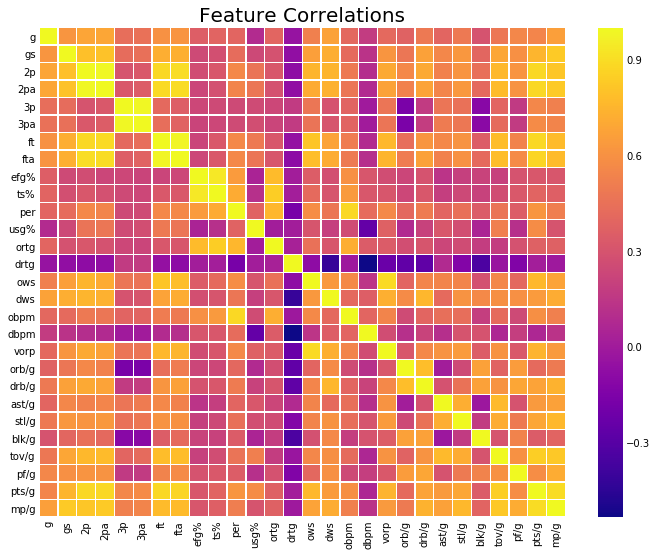

In [26]:
# Correlation plot of features
corr = nba_df[features].corr()

plt.figure(figsize=(10.5,9))

sns.heatmap(corr, cmap='plasma', linewidths=0.3)
plt.title('Feature Correlations', fontsize=20)

plt.savefig('COR_allNBA.png', dpi=300)

In [27]:
nba_df.describe()

,age,season_start,g,gs,mp,fg,fga,2p,2pa,3p,...,mp/g,orb/g,drb/g,trb/g,ast/g,stl/g,blk/g,tov/g,pf/g,pts/g
count,13938.000000,13938.000000,13938.000000,13938.000000,13938.000000,13938.000000,13938.000000,13938.000000,13938.000000,13938.000000,...,13938.000000,13938.000000,13938.000000,13938.000000,13938.000000,13938.000000,13938.000000,13938.000000,13938.000000,13938.000000
mean,26.791075,2004.713517,53.053236,25.880901,1251.691132,195.391017,428.149017,163.491032,338.144928,31.899986,...,20.393521,1.003580,2.570211,3.573863,1.846527,0.658617,0.416430,1.211544,1.889037,8.238470
std,4.221393,8.930435,25.191605,29.287816,916.301539,177.056687,376.295554,157.490284,315.645089,46.147979,...,10.186008,0.853943,1.810427,2.538791,1.842056,0.465851,0.498219,0.804421,0.834665,5.995378
min,18.000000,1989.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,23.000000,1997.000000,33.000000,1.000000,399.250000,47.000000,111.000000,37.000000,82.000000,0.000000,...,11.900000,0.400000,1.200000,1.700000,0.600000,0.300000,0.100000,0.600000,1.300000,3.600000
50%,26.000000,2005.000000,60.000000,11.000000,1165.000000,150.000000,336.000000,117.000000,249.000000,7.000000,...,19.800000,0.800000,2.200000,3.000000,1.200000,0.600000,0.300000,1.000000,1.900000,6.700000
75%,30.000000,2013.000000,76.000000,51.000000,1984.750000,300.000000,656.000000,246.000000,508.000000,51.000000,...,28.900000,1.400000,3.400000,4.800000,2.500000,0.900000,0.500000,1.700000,2.500000,11.700000
max,44.000000,2019.000000,85.000000,83.000000,3533.000000,1034.000000,2173.000000,961.000000,1773.000000,402.000000,...,43.700000,6.800000,12.300000,18.700000,14.500000,3.000000,4.600000,5.700000,6.000000,36.100000


### Import Machine Learning Libraries

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
import tensorflow as tf

### Split dataset into Training and Testing sets

In [29]:
#df = nba_df[(nba_df.season != '2019-20') & (nba_df.ws > 3.0) & (nba_df.mp > 1200)]
df = nba_df[(nba_df.season != '2019-20')]

In [30]:
# Features
X = df[features].values

#Target variables
y = df['all_nba_team']
y_dummy = pd.get_dummies(y).values # One hot encode target variable

# Split data into a training and testing set with 70/30 split.
X_train, X_test, y_train, y_test = train_test_split(X, y_dummy, test_size=0.30)

# Scale the Data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Build DNN Model Function

In [31]:
def model_build(activation, loss, dropout):
    # Create model
   
    model = Sequential()
    
    #Input layer
    model.add(Dense(28, input_dim=X_train.shape[1], activation=activation))
    model.add(Dropout(dropout))
    
    #Hidden layers
    model.add(Dense(14,  activation=activation))
    model.add(Dropout(dropout))
    
    model.add(Dense(8,  activation=activation))
    model.add(Dropout(dropout))
    
    #Output layer with softma activation
    model.add(Dense(4, activation='softmax'))
    
    # Compile model
    model.compile(loss=loss, optimizer='adam', metrics=['accuracy'])
    
    return model

### Define early stop parameter

In [32]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='loss', mode ='min',
                           verbose=0, patience=25)

### Build CV Search Grid

In [33]:
estimator = KerasClassifier(build_fn=model_build, epochs=250, batch_size=25, verbose=0)

# Define the grid search parameters
activation = ['relu', 'sigmoid']
loss_func = ['categorical_crossentropy', 'kullback_leibler_divergence']
dropout = [0, 0.2]
param_grid = dict(activation=activation, loss=loss_func, dropout=dropout)

grid = GridSearchCV(estimator=estimator, param_grid=param_grid, n_jobs=-1, cv=3,)

grid_result = grid.fit(X_train, y_train, validation_data=(X_test, y_test),  
                       callbacks=[early_stop], workers=0)

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.973287 using {'activation': 'sigmoid', 'dropout': 0, 'loss': 'categorical_crossentropy'}
0.969242 (0.006524) with: {'activation': 'relu', 'dropout': 0, 'loss': 'categorical_crossentropy'}
0.970626 (0.002938) with: {'activation': 'relu', 'dropout': 0, 'loss': 'kullback_leibler_divergence'}
0.972435 (0.001482) with: {'activation': 'relu', 'dropout': 0.2, 'loss': 'categorical_crossentropy'}
0.972009 (0.001085) with: {'activation': 'relu', 'dropout': 0.2, 'loss': 'kullback_leibler_divergence'}
0.973287 (0.002572) with: {'activation': 'sigmoid', 'dropout': 0, 'loss': 'categorical_crossentropy'}
0.972648 (0.003913) with: {'activation': 'sigmoid', 'dropout': 0, 'loss': 'kullback_leibler_divergence'}
0.972861 (0.001709) with: {'activation': 'sigmoid', 'dropout': 0.2, 'loss': 'categorical_crossentropy'}
0.972222 (0.001968) with: {'activation': 'sigmoid', 'dropout': 0.2, 'loss': 'kullback_leibler_divergence'}


### Train best model to get history

In [34]:
best_par = grid_result.best_params_

best_estimator = model_build(activation=best_par['activation'], 
                             loss=best_par['loss'], dropout=best_par['dropout'])

history = best_estimator.fit(X_train, y_train,
                             validation_data=(X_test,y_test), 
                             callbacks=[early_stop], epochs=600,  verbose=0)

### Loss Function and Accuracy

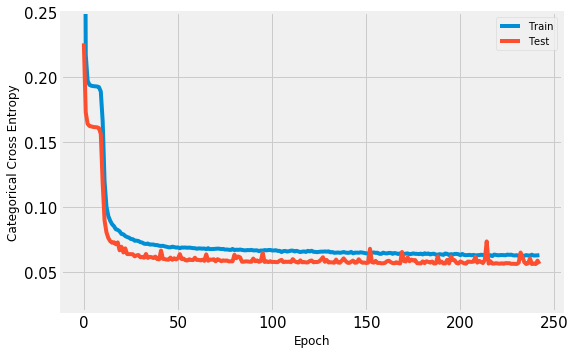

In [58]:
plt.figure(figsize=(8,5.5))
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.ylim(0.02, 0.25)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Categorical Cross Entropy')
plt.savefig('CatCrossEtropyLoss.png', dpi=200, bbox_inches='tight')

Text(0, 0.5, 'Categorical Accuracy')

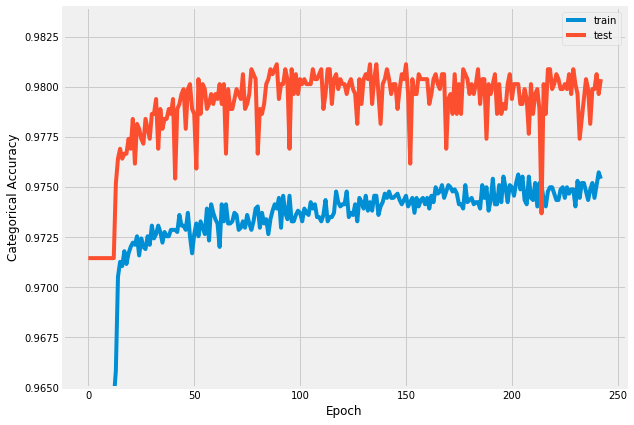

In [54]:
plt.figure(figsize=(9,7))
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.ylim(.965,.984)
plt.xlabel('Epoch')
plt.ylabel('Categorical Accuracy')

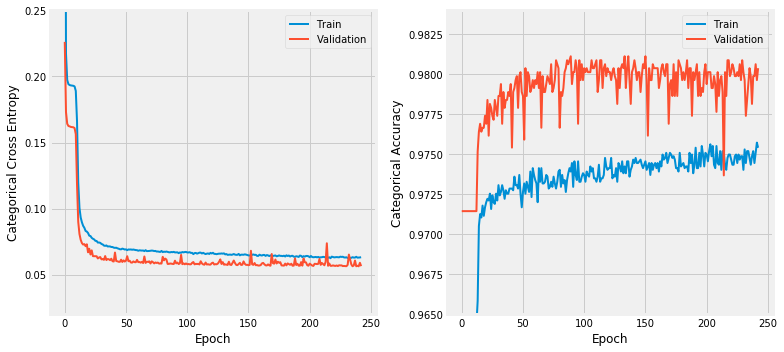

In [72]:
fig, ax = plt.subplots(ncols = 2, figsize = (11, 5))

ax[0].set(xlabel ='Epoch', ylabel = 'Categorical Cross Entropy', ylim = (0.02, 0.25))
ax[0].plot(history.history['loss'], label='Train', lw=2)
ax[0].plot(history.history['val_loss'], label='Validation', lw = 2)
ax[0].legend()

ax[1].set(xlabel = 'Epoch', ylabel = 'Categorical Accuracy', ylim = (0.965, 0.984))
ax[1].plot(history.history['accuracy'], label='Train', lw = 2)
ax[1].plot(history.history['val_accuracy'], label='Validation', lw = 2)
ax[1].legend()

fig.tight_layout()
fig.savefig('LossFunc.png', dpi = 300)

### DNN Model Shape

In [38]:
best_estimator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 28)                812       
_________________________________________________________________
dropout_3 (Dropout)          (None, 28)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 14)                406       
_________________________________________________________________
dropout_4 (Dropout)          (None, 14)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 120       
_________________________________________________________________
dropout_5 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_7 (Dense)              (None, 4)                

### Use model to predict All-NBA Teams for the 2019-20 Season

In [39]:
df_2019 = nba_df[(nba_df.season == '2019-20')][features]
df_2019 = df_2019.values
X_2019 = scaler.transform(df_2019)
prediction = best_estimator.predict_proba(X_2019)

In [40]:
pred_df = pd.DataFrame(prediction, columns = ['1st', '2nd', '3rd', 'NA'])

In [41]:
pred_df = pd.merge(nba_df[(nba_df.season == '2019-20') ] ,pred_df, on=pred_df.index)

In [42]:
pred_df.head()

,key_0,player,age,tm,season_start,season,g,gs,mp,fg,...,stl/g,blk/g,tov/g,pf/g,pts/g,all_nba_team,1st,2nd,3rd,NA
0,0,Steven Adams,26,OKC,2019,2019-20,58,58,1564,262,...,0.9,1.1,1.5,1.9,10.9,no,8.378815e-05,5.052998e-04,0.003715,0.995696
1,1,Bam Adebayo,22,MIA,2019,2019-20,65,65,2235,408,...,1.2,1.3,2.8,2.5,16.2,no,1.320992e-02,9.027956e-02,0.213276,0.683234
2,2,LaMarcus Aldridge,34,SAS,2019,2019-20,53,53,1754,391,...,0.7,1.6,1.4,2.4,18.9,no,6.411058e-06,2.990787e-05,0.000273,0.999691
3,3,Nickeil Alexander-Walker,21,NOP,2019,2019-20,41,0,501,77,...,0.3,0.2,1.0,1.1,5.1,no,1.120350e-07,3.248430e-07,0.000004,0.999996
4,4,Grayson Allen,24,MEM,2019,2019-20,30,0,498,79,...,0.2,0.0,0.8,1.2,7.4,no,1.283231e-07,3.768271e-07,0.000004,0.999995


### Tabulate votes based on weights

In [43]:
pred_df['tabulate'] = pred_df['1st']*5.0 + pred_df['2nd']*3.0 + pred_df['3rd']*1.0


##  ALL-NBA First Team

In [44]:
pred_df[['player', '1st', '2nd', '3rd','tabulate']].sort_values(by = 'tabulate', 
                                                                ignore_index=True,ascending = False)[0:5]

,player,1st,2nd,3rd,tabulate
0,Giannis Antetokounmpo,0.800564,0.175552,0.016772,4.546247
1,LeBron James,0.767275,0.201090,0.021818,4.461464
2,James Harden,0.622205,0.306202,0.047555,4.077184
3,Luka Dončić,0.507557,0.368856,0.078131,3.722486
4,Damian Lillard,0.281257,0.435288,0.163624,2.875771


##  ALL-NBA Second Team

In [45]:
pred_df[['player', '1st', '2nd', '3rd','tabulate']].sort_values(by='tabulate', 
                                                                ignore_index=True, ascending=False)[5:10]

,player,1st,2nd,3rd,tabulate
5,Anthony Davis,0.230673,0.431647,0.190216,2.638520
6,Trae Young,0.184258,0.415130,0.215966,2.382645
7,Kawhi Leonard,0.153912,0.382758,0.233955,2.151791
8,Nikola Jokić,0.047338,0.224948,0.284176,1.195713
9,Russell Westbrook,0.028072,0.155222,0.253525,0.859552


##  ALL-NBA Third Team

In [46]:
pred_df[['player', '1st', '2nd', '3rd','tabulate']].sort_values(by='tabulate', 
                                                                ignore_index=True, ascending=False)[10:15]

,player,1st,2nd,3rd,tabulate
10,Bradley Beal,0.023741,0.149159,0.264947,0.831133
11,Rudy Gobert,0.023606,0.144463,0.266694,0.818114
12,Ben Simmons,0.025699,0.133958,0.230984,0.761352
13,Jimmy Butler,0.021008,0.131898,0.251186,0.751921
14,Joel Embiid,0.014432,0.098998,0.225966,0.595118


## Top 25 Player voting

In [75]:
pred_df[['player', '1st', '2nd', '3rd','NA','tabulate']].sort_values(by='tabulate', 
                                                        ignore_index=True,ascending=False).head(25)

,player,1st,2nd,3rd,NA,tabulate
0,Giannis Antetokounmpo,0.800564,0.175552,0.016772,0.007112,4.546247
1,LeBron James,0.767275,0.201090,0.021818,0.009817,4.461464
2,James Harden,0.622205,0.306202,0.047555,0.024039,4.077184
3,Luka Dončić,0.507557,0.368856,0.078131,0.045456,3.722486
4,Damian Lillard,0.281257,0.435288,0.163624,0.119831,2.875771
5,Anthony Davis,0.230673,0.431647,0.190216,0.147465,2.638520
6,Trae Young,0.184258,0.415130,0.215966,0.184646,2.382645
7,Kawhi Leonard,0.153912,0.382758,0.233955,0.229375,2.151791
8,Nikola Jokić,0.047338,0.224948,0.284176,0.443537,1.195713
9,Russell Westbrook,0.028072,0.155222,0.253525,0.563181,0.859552


In [77]:
pred_df[['player', '1st', '2nd', '3rd','NA','tabulate']].to_csv(r'All-NBA Votes.csv', index=False)